In [12]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Keras imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping

In [ ]:
# run lstm_data_processing.py here

In [14]:

# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [15]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [16]:
# lstm architecture
def build_lstm_model(input_shape, output_units, optimizer_learning_rate):
    model = Sequential()
    model.add(LSTM(units=100, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=output_units, activation='sigmoid'))

    optimizer = Adam(learning_rate=optimizer_learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [17]:

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

x_train, x_test, y_train, y_test = train_test_split(seq_array, label_array, test_size=0.2, random_state=42)

input_shape = (x_train.shape[1], x_train.shape[2])
nb_out = y_train.shape[1]

# Build the LSTM model
model_binary = build_lstm_model(input_shape, nb_out, 0.001)



class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.ravel())
class_weight_dict = dict(enumerate(class_weights))

history_binary = model_binary.fit(
    x_train, y_train,
    epochs=100,
    batch_size=200,
    validation_split=0.05,
    verbose=1,
    callbacks=[early_stop],
    class_weight=class_weight_dict  #class weights
)

# Evaluate the model
binary_predictions = model_binary.predict(x_test) > 0.5  # .5 threshold
binary_accuracy = np.mean(binary_predictions.flatten() == y_test.ravel())
print(f"Binary Classification Accuracy: {binary_accuracy:.2f}")


Epoch 1/100
60/60 [==============================] - 19s 249ms/step - loss: 0.3006 - accuracy: 0.8856 - val_loss: 0.2186 - val_accuracy: 0.9121
Epoch 2/100
60/60 [==============================] - 16s 273ms/step - loss: 0.1267 - accuracy: 0.9478 - val_loss: 0.1106 - val_accuracy: 0.9489
Epoch 3/100
60/60 [==============================] - 14s 231ms/step - loss: 0.1207 - accuracy: 0.9477 - val_loss: 0.0950 - val_accuracy: 0.9665
Epoch 4/100
60/60 [==============================] - 14s 232ms/step - loss: 0.1011 - accuracy: 0.9576 - val_loss: 0.1385 - val_accuracy: 0.9537
Epoch 5/100
60/60 [==============================] - 14s 232ms/step - loss: 0.0932 - accuracy: 0.9593 - val_loss: 0.1957 - val_accuracy: 0.9281
Epoch 6/100
60/60 [==============================] - 14s 242ms/step - loss: 0.0849 - accuracy: 0.9620 - val_loss: 0.0978 - val_accuracy: 0.9601
Epoch 7/100
60/60 [==============================] - 14s 234ms/step - loss: 0.0760 - accuracy: 0.9665 - val_loss: 0.0921 - val_accuracy:

In [18]:

# Generate predictions
binary_predictions = model_binary.predict(x_test) > 0.5

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(y_test, binary_predictions)
print("\nClassification Report:\n", class_report)
class_report_dict = classification_report(y_test, binary_predictions, output_dict=True)


98/98 [==============================] - 2s 18ms/step
Confusion Matrix:
 [[2482   32]
 [  33  580]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2514
         1.0       0.95      0.95      0.95       613

    accuracy                           0.98      3127
   macro avg       0.97      0.97      0.97      3127
weighted avg       0.98      0.98      0.98      3127



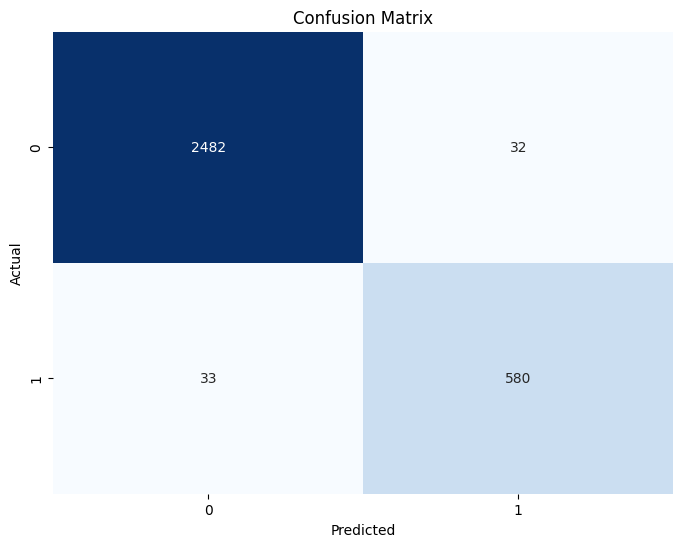

In [19]:

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [20]:

# Update binary model info
binary_model_info = {
    "accuracy": class_report_dict['accuracy'],
    "precision": class_report_dict['weighted avg']['precision'],
    "recall": class_report_dict['weighted avg']['recall'],
    "f1-score": class_report_dict['weighted avg']['f1-score']
}

template_model_info = {
    # source: https://cloudxlab.com/blog/predicting-remaining-useful-life-of-a-machine/
    "accuracy": 0.94,
    "precision": 0.95,
    "recall": 0.8,
    "f1-score": 0.87
}

# Print updated results
print("Binary model:   accuracy = {:.2f},  precision = {:.2f},    recall = {:.2f},  f1-score = {:.2f}".format(
    binary_model_info["accuracy"],
    binary_model_info["precision"],
    binary_model_info["recall"],
    binary_model_info["f1-score"]
))

print("Template model: accuracy = {:.2f},  precision = {:.2f}    recall = {:.2f}  f1-score = {:.2f}".format(
    template_model_info["accuracy"],
    template_model_info["precision"],
    template_model_info["recall"],
    template_model_info["f1-score"]
))


Binary model:   accuracy = 0.98,  precision = 0.98,    recall = 0.98,  f1-score = 0.98
Template model: accuracy = 0.94,  precision = 0.95    recall = 0.80  f1-score = 0.87


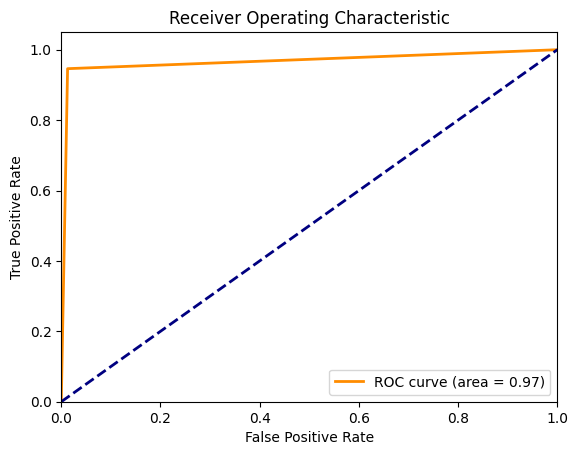

In [21]:

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, binary_predictions)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
